# Lecture #9: Model Evaluation and Selection
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    
    #Create a beta-distributed random variable with shape a, b
    rv = sp.stats.beta(a, b)
    #Create values from 0 to 1
    x = np.linspace(0, 1, 100)
    #Plot the beta pdf for values from 0 to 1
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    #Set title, legend etc
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    
    return ax

#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    #Samples points from a beta distribution 
    #(the posterior of a binomial likelihood and a beta prior is a beta distribution!)
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples


#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode


def plot_priors_with_posteriors(ax, beta_shapes, likes, total_ratings, n_samples):
    #Start the index of the current subplot at 0
    ax_ind = 0
    #Iterate through all the shapes
    for a, b in beta_shapes:
        #Plot the beta pdf for a particular shape
        plot_beta_prior(a, b, 'blue', ax[0, ax_ind])
        #Increment the subplot index
          
        #Draw samples from the posterior corresponding to a particular beta prior
        post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
        #Approximate the posterior with a histogram of these samples
        ax[1, ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
        #Find the approximate mode of the posterior
        mode = find_mode(post_samples, 30)
        #Plot the mode as a vertical line
        ax[1, ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')

        #Set title, legends etc
        ax[1, ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
        ax[1, ax_ind].legend(loc='best')
        #Increment the subplot index
        ax_ind += 1
        
    return ax

## Administrative Matters

1. **Attendance Quiz:** <br><br>

## Outline
1. Review of Statistical Modeling
2. Motivation for Hierarchical Models
3. Hierarchical Models and Empirical Bayes

# Review of Statistical Modeling

## What We Can Do So Far: Models
1. **(Likelihood Models with Observed Variables)** When we have observed data $Y_{\text{Obs}}$, we can model $Y_{\text{Obs}}$ as a random variable $Y_{\text{Obs}} \sim p(Y |\theta)$ with a known distribution $p$.
  - if $Y_{\text{Obs}}$ is a label, we can model it as a *Categorical* or *Bernoulli* variable
  - if $Y_{\text{Obs}}$ is a count, we can model it as a *Binomial*, *Multinomial* or *Poisson*
  - if $Y_{\text{Obs}}$ is continuous, we can model it as a *Gaussian*, *Exponential*, *Dirichlet* etc<br><br>
  
2. **(Likelihood Models with Latent Variables)**  When we also have unobserved data $Z_{\text{Latent}}$, we can model $Z_{\text{Latent}}$ and $Y_{\text{Obs}}$ jointly $p(Y_{\text{Obs}}, Z_{\text{Latent}}| \theta)$.<br><br>
  
3. **(Bayesian Models)**  When we are being Bayesian, we *assume* a prior for $\theta$, encoding our knowledge and uncertainty about $\theta$. We model parameters and data jointly $p(Y_{\text{Obs}}, \theta)$ or $p(Y_{\text{Obs}}, Z_{\text{Latent}}, \theta)$.

## What We Can Do So Far: Inference
We can make statements about $\theta$ by performing:

**I.** ***Maximum Likelihood Estimation:*** for likelihood models, we compute a fixed value $\theta_{\text{MLE}}$ that maximizes the likelihood of the observed data $Y$.
   
**II.** ***Bayesian Inference:*** for Bayesian models, we compute the posterior distribution $p(\theta| Y)$. 

We choose an ***inference algorithm or method*** to perform inference:

**I.** ***Maximum Likelihood Estimation:*** <br>
   **A.** For *models with observed variables*, we *analytically* solve an unconstrained or contrained optimization problem to obtain $\theta_{\text{MLE}}$.<br>
   **B.** For *latent variable models*, we use ***expectation maximization*** to approximately find $\theta_{\text{MLE}}$.
  
**II.** ***Bayesian Inference:*** <br>
  **A.** If the prior and likelihood are ***conjugate***, *analytically* derive the posterior distribution<br>
  **B.** If the posterior distribution does not have a known form, sample from it using a ***sampler***.<br>
  **C.** If the posterior distribution does not have a known form, approximate it using ***variational inference***.

## What Can We Not Do?
**1.** (***Regression Models***) We don't have any models where some observed variables $Y_{\text{Obs}}$ depend on other observed variables $X_{\text{Obs}}$, i.e. none of our models have covariates that we condition on. 

**2.** (***Gradient Descent Methods***) Analytically optimizing the log-likelihood is not always possible, and when possible it is extremely annoying to do by hand. 
*Can we find a way to black-box optimize any objective function?* 
  
**3.** (***Hamiltonian Monte Carlo***) MCMC samplers can be extremely inefficient in high-dimensions where the samplers struggle to find area of high mass in the target distribution. 
*Can we build a proposal distribution with an indicator of where the target distribution mass is located?* 

**4.** (***Black-box Variational Inference etc***) Variational inference sounds like a great idea but maximizing the ELBO using coordinate ascent is an artisenal process that requires a massive amount of derivations per model. 
*Can we find an algorithm to compute/estimate the gradient of the ELBO that is model independent? Can we perform black-box variational inference?*
  
**5.** (***Stochastic Systems, Hidden Markov Models***) We have no models for non-iid data, in particular, we have no models for sequential data (where the next data point depend on the previous). 

## What Happens After Inference?

1. **(Predictive Evaluation)** In practice, we do not know the true model $\theta_{\text{True}}$! Thus, $\theta_{\text{MLE}}$ and $p(\theta|Y)$ cannot be evaluated by comparison to $\theta_{\text{True}}$.
  - ***Maximimum Likelihood Estimation:*** we compute $\theta_{\text{MLE}}$ on multiple bootstrap samples of the data; for each $\theta_{\text{MLE}}$ we sample $Y \sim p(Y| \theta_{\text{MLE}})$. We compare these samples with observed data $Y_{\text{Obs}}$.
  - ***Bayesian Inference:*** we sample $\theta$'s from the posterior, for each $\theta_{\text{MLE}}$ we sample $Y \sim p(Y| \theta_{\text{MLE}})$. We compare these ***posterior predictive samples*** with the observed data $Y_{\text{Obs}}$.<br><br>

2. **(Uncertainty Evaluation)** Before making decisions with real-life consequence based on your model, you should check the precision of your estimate or uncertainty of you model.
  - ***Maximimum Likelihood Estimation:*** repeat the MLE computation on many bootstrap samples of $Y_{\text{Obs}}$. Compute the confidence interval of $\theta$ and the predictive interval for $Y$. These intervals indicate *precision*.
  - ***Bayesian Inference:*** Compute credible intervals for the posterior $p(\theta|Y)$ and the predictive intervals of the posterior predictive. These intervals indicate *model uncertainty*.

## The Modeling Process

<img src="fig/modeling.jpg" style="height:250px;">

## Evaluating the Predictive Distributions

How well does the predictive distribution of bootstrapped MLE models or the posterior predictive of a Bayesian model capture the actual observed data?

We cannot, in general, perform visual chekcks (i.e. plot the predictive and the data). To quantify how well a predictive distribution aligns with the actual data we can compute:
1. The KL-divergence between actual data (***empirical distirbution***) and our predictive distribution.
2. The log-likelihood of the actual data.

  **A.** For MLE models: we can compute $\log p(Y^{\text{Obs}}| \theta_{\text{MLE}})$ for each bootstrap $\theta_{\text{MLE}}$ and then average the log-likelihood over the number of bootstraps. If there are multiple observations, we would sum the individual log-likelihoods at the end.<br><br>
  
  **B.** For Bayesian models: we evaluate the observed data under the posterior predictive,  
  $$
  \log \prod_{n=1}^N \int_{\Theta} p(Y^{\text{Obs}}_n | \theta) p(\theta|Y^{\text{Obs}}_1, \ldots, Y^{\text{Obs}}_N) d\theta \approx \sum_{n=1}^N\log \frac{1}{S} \sum_{s=1}^S p(Y^{\text{Obs}}_n | \theta_s), 
  $$
  where $\theta_s\sim p(\theta|Y^{\text{Obs}}_1, \ldots, Y^{\text{Obs}}_N)$

In [3]:
## generate training data
#number of points in each of the two segments of the domain
N = 100
#training x
x_1 = np.hstack((np.linspace(-10, -5, N), np.linspace(5, 10, N)))
x_2 = np.linspace(-10, 10, 2 * N)
#output noise variance
y_var = 1.0
#function relating x and y
f = lambda x:  0.01 * x**3
#y is equal to f(x) plus gaussian noise
y_1 = f(x_1) + np.random.normal(0, y_var, 2 * N)
y_2 = f(x_2) + np.random.normal(0, y_var, 2 * N)

#prior variance for the bayesian model
prior_var = 10.

## generate testing data
#nubmer of testing points
N_test = 100
#testing x
x_test = np.linspace(-10, 10, N_test)
y_test = f(x_test) + np.random.normal(0, y_var, N_test)

#total number of bootstrap estimates of the MLE
trials = 1000
#set up for polynomial (deg 7) regression
linear_model = LinearRegression()
poly = PolynomialFeatures(7)

In [4]:
def mle_vs_bayesian(x, y, ax, prior_var=1.):
    #transform training x: add polynomial features
    x_poly = poly.fit_transform(x.reshape((-1, 1)))
    #transform x_test: add polynomial features
    x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    #Gaussian log pdf
    gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)
    
    ##fit mle on multiple bootstraps
    log_likelihood = []
    y_predict = []
    for n in range(trials):
        #create bootstrap sample from data
        x_bootstrap = np.random.choice(x, size=len(x), replace=True)
        #add polynomial features
        x_bootstrap_poly = poly.fit_transform(x_bootstrap.reshape((-1, 1)))
        #compute MLE for the coefficients/parameters of the polynomial model 
        linear_model.fit(x_bootstrap_poly, f(x_bootstrap) + np.random.normal(0, y_var, 2 * N))
        #predict on x_test using your MLE model
        prediction = linear_model.predict(x_test_poly)
        y_predict.append(prediction + np.random.normal(0, y_var, N_test))
        #compute log-likelihood of test data
        log_likelihood.append(gaussian_log_pdf(prediction, y_var, y_test).sum())
    y_predict = np.array(y_predict)
    log_likelihood = np.array(log_likelihood)
    
    #compute the 95 percentiles of the predictions
    ub = np.percentile(y_predict, 97.5, axis=0)
    lb = np.percentile(y_predict, 2.5, axis=0)
    
    ax[0].scatter(x, y, color='red', s=10, alpha=0.5, label='train data')
    ax[0].scatter(x_test, y_test, color='black', s=10, alpha=0.5, label='test data')
    ax[0].fill_between(x_test, ub, lb, color='gray', alpha=0.4, label="avg test log-likelihood: {}".format(np.round(np.mean(log_likelihood), 4)))
    ax[0].set_title('predictive distribution for {} bootstrap estimates of the MLE'.format(trials))
    ax[0].legend(loc='best')
    ax[0].set_xlim([-10, 10])
    
    #number of samples from the posterior
    S = trials
    #add a column of one's representing the bias
    x_matrix = np.hstack((x_poly, np.ones((x_poly.shape[0], 1))))
    #add a column of one's representing the bias
    x_test_matrix = np.hstack((x_test_poly, np.ones((x_test_poly.shape[0], 1))))
    #reshape y into 2D array
    y_matrix = y.reshape((-1, 1))

    #define the covariance and precision matrices of the prior on the weights
    prior_variance = np.diag(prior_var * np.ones((x_matrix.shape[1], )))
    prior_precision = np.linalg.inv(prior_variance)

    #defining the posterior variance
    joint_variance = np.linalg.inv(prior_precision + 1. / y_var * x_matrix.T.dot(x_matrix))
    #defining the posterior mean
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) * 1. / y_var

    #sampling S points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=S)
    #sampling S points from the posterior predictive
    y_predict_noiseless = np.array([x_test_matrix.dot(sample) for sample in posterior_samples])
    y_predict_bayes = y_predict_noiseless + np.random.normal(0, y_var, size=(S, N_test))
    
    log_likelihood_bayes = []
    #compute log likelihood for the test data
    for n in range(len(y_test)):
        log_likelihood_bayes.append(gaussian_log_pdf(y_predict_noiseless[:, n], y_var, y_test[n]).mean())
        
    log_likelihood_bayes = np.array(log_likelihood_bayes)
    

    #compute the 95 percentiles of the posterior predictives
    ub_bayes = np.percentile(y_predict_bayes, 97.5, axis=0)
    lb_bayes = np.percentile(y_predict_bayes, 2.5, axis=0)
    
    ax[1].scatter(x, y, color='red', s=10, alpha=0.5, label='train data')
    ax[1].scatter(x_test, y_test, color='black', s=10, alpha=0.5, label='test data')
    ax[1].fill_between(x_test, ub_bayes, lb_bayes, color='blue', alpha=0.4, label="test log-likelihood: {}".format(np.round(np.sum(log_likelihood_bayes), 4)))
    ax[1].set_title('posterior predictive distribution of bayesian regression model with prior variance of {}'.format(prior_var))
    ax[1].legend(loc='best')
    ax[1].set_xlim([-10, 10])
    
    return ax, log_likelihood_bayes

## Interpreting the Log-Likelihood of Actual Data

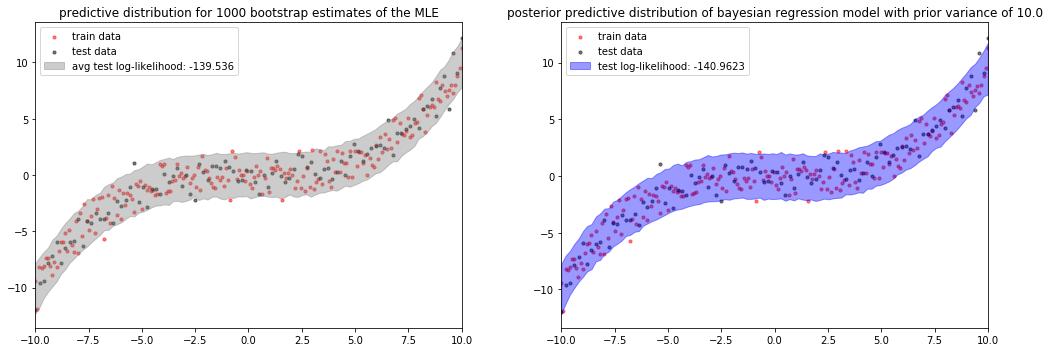

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
prior_var = 10.
ax, log_likelihood_bayes = mle_vs_bayesian(x_2, y_2, ax, prior_var=prior_var)
plt.tight_layout()
plt.show()

## Evaluating and Quantifying Uncertainty

How do we know our model uncertainties (confidence intervals, credible intervals, predcitive intervals, posterior predictive intervals) are any good? What information about the data/model do we want our uncertainties to capture?

**Epistemic Uncertainty:** uncertainty due to small number of samples across all scenarios. This can be reduced by more samples!

**Aleatoric Uncertainty:** uncertainty due to the underlying randomness of the data generation process. This cannot be reduced no matter what.

Can we use log-likelihood of as a metric for the quality of predictive uncertainty?

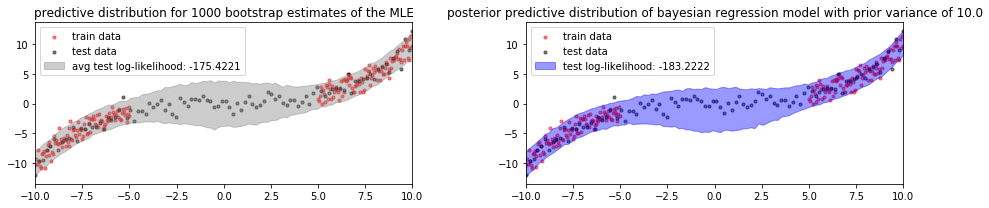

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
ax = mle_vs_bayesian(x_1, y_1, ax, prior_var=prior_var)
plt.tight_layout()
plt.show()

# Motivation for Hierarchical Models

## A Binomial Model for Movie Rankings

We model the number of likes $Y_n$ received by the $n$-th movie as a binomial variable $Y_n | \theta_n\sim Bin(R_n, \theta_n)$, where $R_n$ is the number of times the $n$-th movies was rated and $\theta_n$ is the "likeability" of the movie.

In [7]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [8]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|', encoding = "ISO-8859-1")
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


In [9]:
#Make a list of movie names and their ratings info
likability_list = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability_list.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability_list, key=lambda t: t[3], reverse=True)  
#Get the movies with top like-percentage
top_movies = sorted_likability[:10]

In [10]:
#Print results of ranking
print('Top 10 Movies')
print('****************************')
for movie, likes, total_ratings, likable in top_movies:
    print (movie, ':', likable, '({}/{})'.format(likes, total_ratings))

Top 10 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)


## A Beta-Binomial Model for Movie Rankings

We model the number of likes $Y_n$ received by the $n$-th movie as a binomial variable $Y_n | \theta_n\sim Bin(R_n, \theta_n)$, we model our prior beliefs and uncertainty about $\theta$ using a beta distribution $\theta_n \sim Beta(\alpha, \beta)$.

In [11]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (9, 9), (9, 2), (2, 9)]
#Length of the list of shapes
n = len(beta_shapes)

#Get the name of the first movie in the top 25 list
movie_name = top_movies[0][0]

#Get the ratings info for the first movie in the top 25 list
likes = top_movies[0][1]
total_ratings = top_movies[0][2]
likability = top_movies[0][3]

#Number of samples to use when approximating our posterior
samples = 10000

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


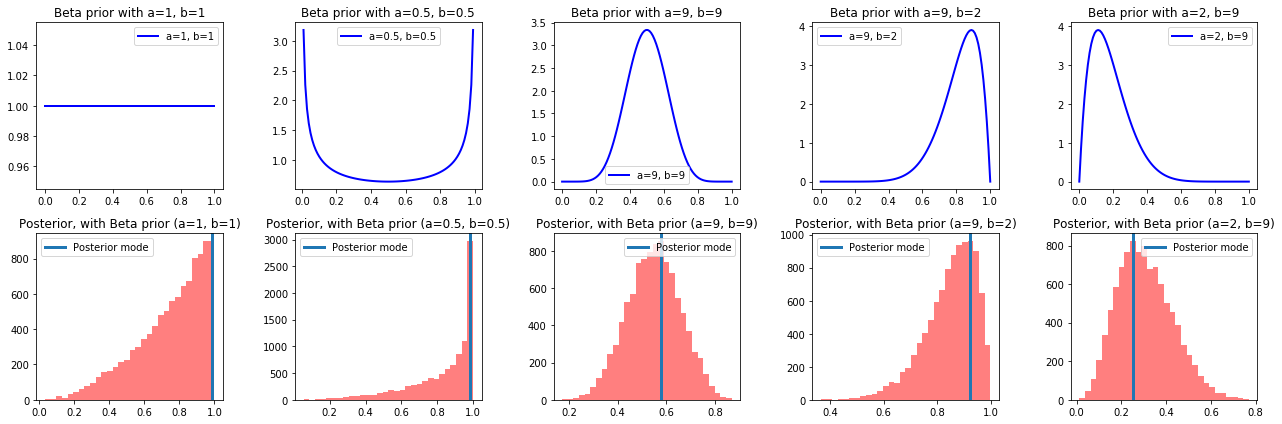

In [12]:
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))
fig, ax = plt.subplots(2, n, figsize=(18, 6))
ax = plot_priors_with_posteriors(ax, beta_shapes, likes, total_ratings, samples)
plt.tight_layout()    
plt.show() 

## Credible Intervals for Movies with the Most and the Least Number of Ratings

In [13]:
#paramters of our beta prior
a = 0.5
b = 0.5
#sort our list of movie info by like-percentage, in descending order
sorted_total_ratings = sorted(likability_list, key=lambda t: t[2], reverse=True)  

top_n = 10

##function to compute and plot the credible intervals for the movies with the most number of ratings
##and the movies with the least number of ratings
def plot_credible_intervals(a, b, ax):
    S = 1000
    movie_names = []
    for i in range(top_n):
        #compute the credible intervals of the movies with the most number of ratings
        post_samples = sample_posterior(a, b, sorted_total_ratings[i][1], sorted_total_ratings[i][2], S)
        ub = np.percentile(post_samples, 97.5)
        mean = np.percentile(post_samples, 50.0)
        lb = np.percentile(post_samples, 2.5)
        movie_names.append((top_n - (i + 1), sorted_total_ratings[i][0]))
        
        #plot the credible intervals
        if i == 0:
            ax.hlines(top_n - (i + 1), lb, ub, colors='purple', linewidth=1, label='credible interval of most rated')
            ax.scatter([mean], [top_n - (i + 1)], color='purple', label='posterior mean of most rated')
            ax.scatter([sorted_total_ratings[i][1] * 1. / sorted_total_ratings[i][2]], [top_n - (i + 1)], marker='x', color='purple', label='MLE most rated')
        else:
            ax.hlines(top_n - (i + 1), lb, ub, colors='purple', linewidth=1)
            ax.scatter([mean], [top_n - (i + 1)], color='purple')
            ax.scatter([sorted_total_ratings[i][1] * 1. / sorted_total_ratings[i][2]], [top_n - (i + 1)], marker='x', color='purple')
        
        #compute the credible intervals of the movies with the least number of ratings
        post_samples = sample_posterior(a, b, sorted_total_ratings[-(i + 1)][1], sorted_total_ratings[-(i + 1)][2], S)
        ub = np.percentile(post_samples, 97.5)
        mean = np.percentile(post_samples, 50.0)
        lb = np.percentile(post_samples, 2.5)
        movie_names.append((-top_n + i, sorted_total_ratings[-(i + 1)][0]))
        
        #plot the credible intervals
        if i == 0:
            ax.hlines(-top_n + i, lb, ub, colors='green', linewidth=1, label='credible interval of least rated')
            ax.scatter([mean], [-top_n + i], color='green', label='posterior mean of least rated')
            ax.scatter([sorted_total_ratings[-(i + 1)][1] * 1. / sorted_total_ratings[-(i + 1)][2]], [-top_n + i], marker='x', color='green', label='MLE least rated')
        else:
            ax.hlines(-top_n + i, lb, ub, colors='green', linewidth=1,)
            ax.scatter([mean], [-top_n + i], color='green')
            ax.scatter([sorted_total_ratings[-(i + 1)][1] * 1. / sorted_total_ratings[-(i + 1)][2]], [-top_n + i], marker='x', color='green')

            
        #compute the MLE of the pooled data
        total_likes = np.sum([rating[1] for rating in sorted_total_ratings])
        total_ratings = np.sum([rating[2] for rating in sorted_total_ratings])
            
        movie_names = sorted(movie_names, key=lambda x: x[0])
        
    ax.axvline(x=total_likes * 1. / total_ratings, color='red', label='MLE of pooled data')
    ax.legend(loc='best')
    ax.set_yticks(np.arange(-top_n, top_n + 1))
    ax.set_yticklabels([name[1] for name in movie_names])
    return ax

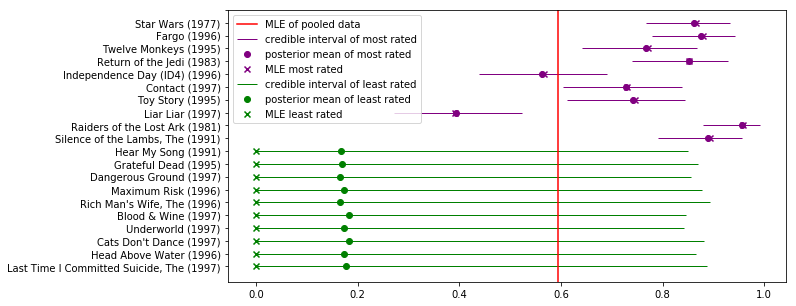

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_credible_intervals(a, b, ax)
plt.show()

## Emprirical Bayes (ML-II) For the Beta-Binomial Model

Since the prior has a significant impact on the posterior when the number of ratings is small, we want to choose a prior that is appropriate for the data. 

**Idea:** choose the hyperparameters $\alpha, \beta$ for the beta prior such that the expected likelihood of the data, over $\theta_n \sim Beta(\alpha, \beta)$, is maximized:

\begin{aligned}
p(Y_1, \ldots, Y_N| \alpha, \beta) = \prod_{n=1}^N \int_0^1 Bin(Y_n|R_n, \theta_n) Beta(\theta_n|\alpha, \beta)d\theta_n = \prod_{n=1}^N {R_n \choose Y_n}\frac{B(\alpha + Y_n, \beta + R_n - Y_n)}{B(\alpha, \beta)}
\end{aligned}

where $B$ is the beta function. The marginal likelihood of the data $p(Y_1, \ldots, Y_N| a, b)$ is called ***evidence***.

This method of choosing the hyperparameters of the prior based on the data is called ***empirical Bayes*** or ***type-II maximum likelihood***.

**Question:** doens't this violate the principle of choosing the prior independent of the data?

## Method of Moments for Empirical Bayes (ML-II)
Since each marginal $p(Y_n| \alpha, \beta)$ is a Beta-Binomial distribution, we know its first two moments:

\begin{aligned}
\mathbb{E}\left[Y_n\right] &=  R_n \frac{\alpha}{\alpha + \beta}\\
\text{Var}\left[Y_n\right] &= \frac{R_n \alpha\beta}{(\alpha + \beta)^2}\frac{\alpha + \beta + R_n}{\alpha + \beta + 1}
\end{aligned}

Now we can make the simplyfying approximations that the $Y_n$'s are iid data from the *same* binomial, i.e. all have the same moments as above. Then we can use empirical moments to approximate the theoretical moments and solve for $\alpha, \beta$:

\begin{aligned}
\widehat{\mathbb{E}}\left[\frac{Y_n}{R_n}\right] &=  \frac{\alpha}{\alpha + \beta}\\
\widehat{\text{Var}}\left[\frac{Y_n}{R_n}\right] &= \frac{\alpha\beta}{\overline{R}_n (\alpha + \beta)^2}\frac{\alpha + \beta + \overline{R}_n}{\alpha + \beta + 1}
\end{aligned}

where $\widehat{\mathbb{E}}$ is sample mean and $\widehat{\text{Var}}$ is sample variance and $\overline{R}_n$ is the average total number of ratings.

In [15]:
mean = np.mean([rating[1] * 1. / rating[2] for rating in sorted_total_ratings])
variance = np.std([rating[1] * 1. / rating[2]  for rating in sorted_total_ratings])**2
R_mean = np.mean([rating[2] for rating in sorted_total_ratings])

alpha_eb = 0.897869
beta_eb = 0.912247

## Empirical Bayes and Shrinkage

Computing the hyperparameters $\alpha, \beta$ of the beta prior on $\theta$ from the data, allows the ratings rich movies to influence the prior of ratings poor movies, since all movies contribute to the empirical Bayes estimate. 

As a result, the estimates from ratings poor movies tend to ***shrink*** towards the population mean more so than ratings rich movies.

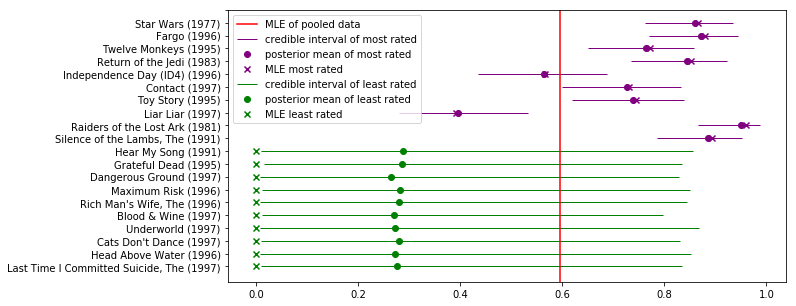

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_credible_intervals(alpha_eb, beta_eb, ax)
plt.show()

# Hierarchical Models and Empirical Bayes

## A Hierarchical Model for Movie Rankings

We model the number of likes $Y_n$ received by the $n$-th movie as a binomial variable $Y_n|\theta_n\sim Bin(R_n, \theta_n)$, we model our prior beliefs and uncertainty about $\theta$ using a beta distribution $\theta_n \sim Beta(\alpha, \beta)$; finally, we model our uncertainty about $\alpha, \beta$ using uniform distributions $\alpha, \beta\sim U(0.5, 100)$:

\begin{aligned}
\alpha, \beta &\sim U(0.5, 100)\\
\theta_n | \alpha, \beta &\sim Beta(\alpha, \beta)\\
Y_n|\theta_n &\sim Bin(R_n, \theta_n)
\end{aligned}

This is an example of a ***hierarchical model*** -- a model with multiple layers of unknown variables. 

There are overlaps between hierarchical models and latent variable models. Generally, we want the hiearchy in a ***hierarchical model*** to express scientifically meaningful conditional relationships. In ***latent variable models*** we want the latent variable to represent unknown aspects of the data rather than unknown parameters of our model.

## Point Estimate Approximations of Inference in Hierachical Models (MAP-II)

The posterior of the hierarchical model for movie ratings is $p(\alpha, \beta, \theta_1, \ldots, \theta_N | Y_1, \ldots, Y_N)$, but since we know how $\theta_n$ is conditioned on $\alpha, \beta$, it is often easier to marginalize out $\theta_n$ and work with $p(\alpha, \beta |Y_1, \ldots, Y_N)$.

The central idea is that by infering the posterior $p(\alpha, \beta |Y_1, \ldots, Y_N)$, $\alpha$ and $\beta$ are influenced by the entire data set and thus ratings poor movies can ***borrow statistical strength*** from ratings rich movies through the way $\theta_n$ depends on $\alpha, \beta$.

However, performing full Bayesian inference on hierarchical models can be difficult. Thus, we can make a point estimate approximation of $p(\alpha, \beta |Y_1, \ldots, Y_N)$:

$$\alpha^*, \beta^* = \text{argmax}_{\alpha, \beta} p(\alpha, \beta |Y_1, \ldots, Y_N).$$

When we perform the usual Bayesian inference on $p(Y_n|\theta_n)p(\theta_n|\alpha^*, \beta^*)$, this is called the ***type-II MAP method***.

But when $\alpha, \beta$ are uniform random varibles, the above becomes:

$$\alpha^*, \beta^* = \text{argmax}_{\alpha, \beta} p(Y_1, \ldots, Y_N |\alpha, \beta),$$

When we perform the usual Bayesian inference on $p(Y_n|\theta_n)p(\theta_n|\alpha^*, \beta^*)$, this is just our empirical Bayes or type-II MLE method!